# Wavelets in Python

---

## Overview

Computes the wavelet of time-series data

- Wavelet Overview
- Wavelet Implementation: PyWavelets
- Example: PyWavelets Morlet Power Spectrum

## Background

Wavelets are a powerful tool for analyzing time-series data. Time-series data is data that depends on time as well as frequency. For example, modeling changes in temperature across atmospheric data over time or analyzing a short audio sample where a limited number of notes can be repeated in any order.

Fourier Transform is the most common form of signal processing. Fourier Transforms can return precise information about the frequencies present in a signal (known as the frequency domain). However, due to the Uncertainty Principle, it is impossible to know the exact frequency (frequency domain) and exact time (time domain) when a frequency occurs.

Wavelet transforms provide a potential solution and can be used to return an analysis with both time and frequency at a cost of reduced precision in frequency. Wavelets work by squishing and stretching a known wave (known as a Mother Wavelet) to match a range of possible frequencies over the short length of a signal. The modified squished/stretched wavelet (known as a Daughter Wavelet) will be shifted along the entire signal to compare the known wavelet frequency with the signal. Because the comparison occurs over a known time range with a known wavelet frequency, wavelet analysis can return data both about the frequency of the signal and the time in which it occurs.

## Wavelet Inputs

- x: Input time-series data, for example: time and temperature in [nino3_sst](https://paos.colorado.edu/research/wavelets/wave_idl/nino3sst.txt)
- wavelet: mother wavelet name
- dt: sampling period (time between each y-value)
- s0: smallest scale
- dj: spacing between each discrete scales
- jtot: largest scale

## Mother Wavelet
There are many different kinds of wavelets to choose from. The three most common (and used by NCL) are Morlet, Paul, and DOG. During wavelet analysis, a Mother wavelet is squished/stretched into many different Daughter wavelets based on the scales to fit different shaped waves. A Mother wavelet is chosen based on the characteristics of the data and the features that are being investigated

Some wavelets include: Mexican Hat, Morlet, Complex Morlet, Gaussian Derivative, Complex Gaussian Derivative, Shannon, etc..

![example_wavelets](example_of_wavelets.png)

## Choosing Wavelet Scales

Scales determine the range that the wavelet analysis is senstitive to where:

- Large scales correspond to stretched wavelets that are sensitive to low frequencies
- Small scales correspond to squished wavelets that are sensitive to high frequencies

The smallest scale is most commonly equal to:

```
s0 = 2 * sampling period

s0 = 2 * dt
```
- Note: NCL sets smallest scale (s0) to sampling period when using Morlet wavelet (s0=dt)
- Note: NCL sets smallest scale (s0) to 1/4th of the sampling period when using Paul wavelet (s0=dt/4)

The largest scale is most commonly equal to:

```
jtot = 1 + floattointeger(((log10(N*dt/s0))/dj)/log10(2.)) 

jtot = 1 + int(((log10(length of input data * sampling period/smallest scale))/spacing between each discrete scales)/log10(2))
```

The spacing between scales is commonly equal to 0.25 (dj=0.25) where a smallest spacing will produce a greater resolution of data but will run slower

## Wavelets Example in Python using PyWavelets

### [PyWavelets: pywt.cwt](https://pywavelets.readthedocs.io/en/latest/ref/cwt.html#pywt.cwt)

Wavelet analysis is accomplished in Python via external package. PyWavelets is an open source Python package for applying wavelet analysis. 

```
coeffs, freqs = pywt.cwt(data, scales, wavelet, sampling_period)
```

#### Input Values
- data: inpt data as a array_like
- scales: array_like collection of the scales to use (np.arange(s0, jtot, dj))
- wavelet: name of Mother wavelet
- sampling_period: optional sampling period for frequencies output

#### Return Value
- coefs: array_like collection of complex number output for wavelet coefficients
- freqs: array_like collection of frequencies


### PyWavelets: Morlet Wavelet

The Morlet wavelet is a complex wavelet, with both a real and imaginary component. In PyWavelets this is known as a Complex Morlet ("cmor").

NCL Morlet wavelet is based on "A Practical Guide to Wavelet Analysis" (Torrence and Compo). However, PyWavelets functions are derived from "Computational Signal Processing with Wavelets" (Teolis)  to be compatible with how [Matlab is defined](https://www.mathworks.com/help/wavelet/ref/cmorwavf.html)). To match the expected behavior of PyWavelets best to NCL, the differences will be noted below.

In [2]:
import math  # access to pi and square root (math.pi, math.sqrt)
import numpy as np  # access to complex numbers (real and imaginary)
import cmaps  # access to NCL default plot colors
import matplotlib.pyplot as plt  # plot data

import pywt  # PyWavelets

### Define the Complex Morlet

PyWavelets defines a [Complex Morlet](https://pywavelets.readthedocs.io/en/latest/ref/cwt.html#complex-morlet-wavelets) Mother wavelet as `cmorB-C` where B is the bandwidth and C is the center frequency.

To match the Morlet wavelet function being used by NCL (Torrence and Compo, Table 1) and the PyWavelets complex morlet (Teolis, pg. 65-66), set bandwidth value `B=sqrt(pi)` and center frequency `C=6/2*pi`

![compare_tc_cmor](compare_tc.png)

### *Note* 

The Complex Morlet in PyWavelets will match along the x-intercept, but will be a smaller amplitude by `2 * fourth root of pi`. The x-intercepts are the most important feature of the wavelet, but to match completely set bandwidth `B=2` and multiple entire output by `math.sqrt(2)*np.power(math.pi, 1/4)`

In [3]:
# Set up `cmor` Complex Morlet to match x-intercept
bandwidth = math.sqrt(math.pi)
center_freq = 6 / (2 * math.pi)
wavelet_mother = f"cmor{bandwidth}-{center_freq}"
print(wavelet_mother)

cmor1.7724538509055159-0.954929658551372


In [4]:
# Download nino3 data
nino_url = 'https://paos.colorado.edu/research/wavelets/wave_idl/nino3sst.txt'
sst_data = np.genfromtxt(nino_url, skip_header=19)

In [5]:
# PyWavelet Input Values
dt = 0.25  # sampling period (time between each y-value)
s0 = 0.25  # smallest scale
dj = 0.25  # spacing between each discrete scales
jtot = 44  # largest scale
scales = np.arange(1, jtot + 1, dj)
wavelet_coeffs, freqs = pywt.cwt(
    data=sst_data, scales=scales, wavelet=wavelet_mother, sampling_period=dt
)

## Power Spectrum

`wavelet_coeffs` is a complex number with a real and an imaginary number (1 + 2i). The power spectrum plots the real component of the complex number

```
real_component = abs(wavelet_coeffs)
```

The real component represents the magntiude of the wavelet coefficient displayed as the absolute value of the coefficients squared

In [6]:
# compare the power spectrum (absolute value squared)
power = np.power((abs(wavelet_coeffs)), 2)

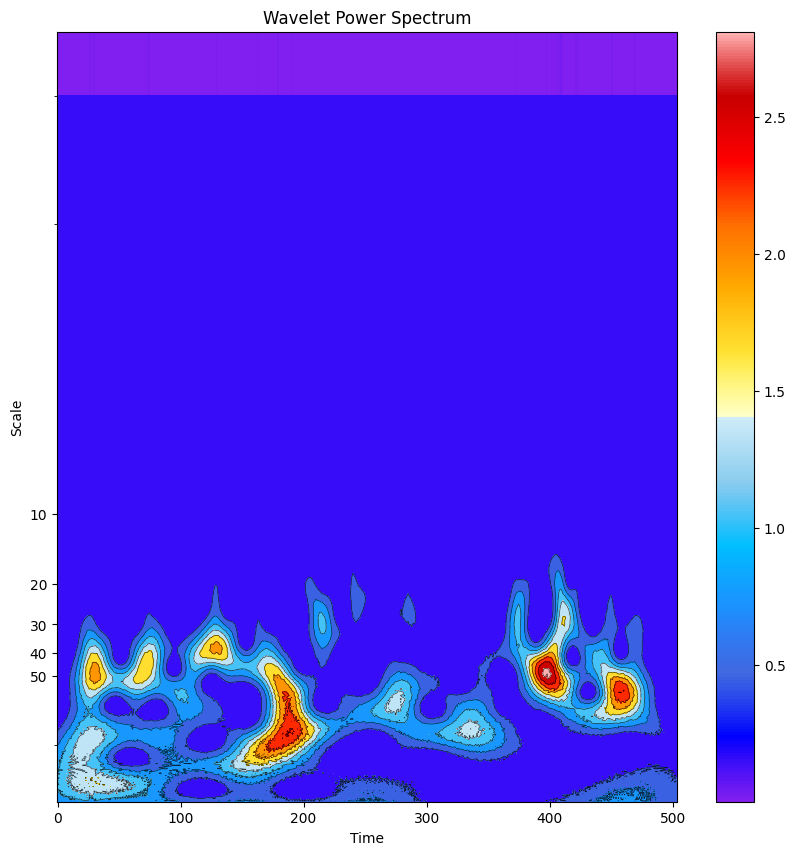

In [7]:
# Plot scalogram
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_yscale("symlog")
ax.invert_yaxis()
ax.set_yticks([10, 20, 30, 40, 50])
ax.set_yticklabels([10, 20, 30, 40, 50])

plt.contourf(
    power, vmax=(power).max(), vmin=(power).min(), cmap=cmaps.ncl_default, levels=10
)
plt.contour(power, levels=10, colors="k", linewidths=0.5, alpha=0.75)

plt.title("Wavelet Power Spectrum")
plt.xlabel("Time")
plt.ylabel("Scale")
plt.imshow(
    power, vmax=(power).max(), vmin=(power).min(), cmap=cmaps.ncl_default, aspect="auto"
)
plt.colorbar()
plt.show()

## Phase Spectrum

`wavelet_coeffs` is a complex number with a real and an imaginary number (1 + 2i). While less commonly used in frequency and signal analysis, the phase spectrum plots the imaginary component of the complex number

```
import numpy as np

# note: np.angle() returns the angle of a complex number

imaginary_component = np.angle(wavelet_coeffs)
```

The imaginary component represents the direction of the wavelet coefficient

In [8]:
# compare the phase spectrum
phase = np.angle(wavelet_coeffs)

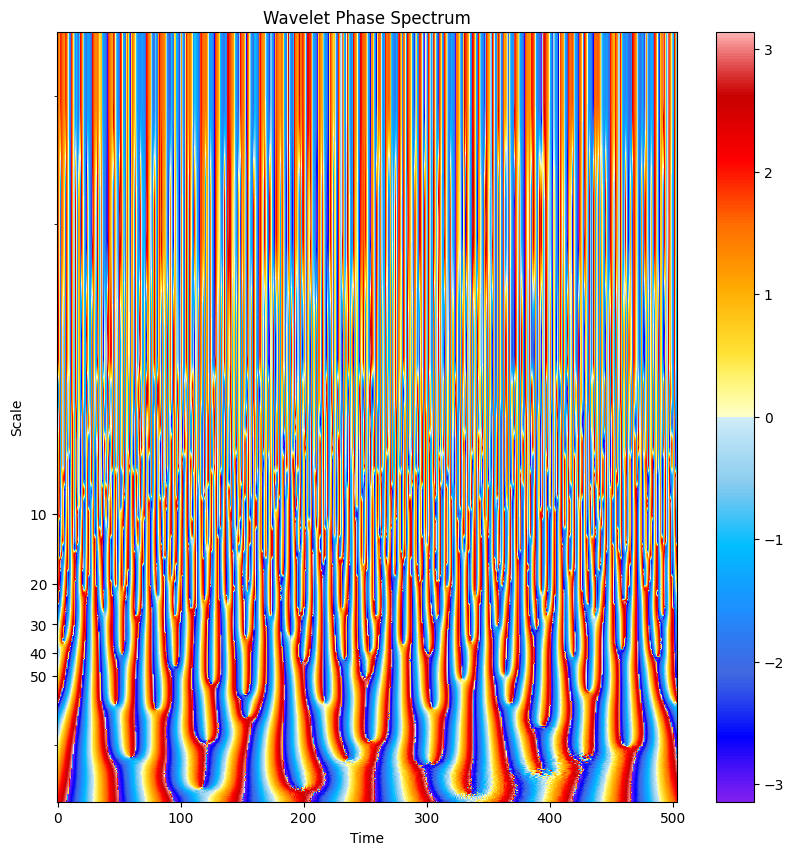

In [10]:
# Plot scalogram
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_yscale("symlog")
ax.invert_yaxis()
ax.set_yticks([10, 20, 30, 40, 50])
ax.set_yticklabels([10, 20, 30, 40, 50])

plt.title("Wavelet Phase Spectrum")
plt.xlabel("Time")
plt.ylabel("Scale")
plt.imshow(
    phase, vmax=(phase).max(), vmin=(phase).min(), cmap=cmaps.ncl_default, aspect="auto"
)
plt.colorbar()
plt.show()

## Further Reading

- [PyWavelets Continuous Wavelet Transform (CWT)](https://pywavelets.readthedocs.io/en/latest/ref/cwt.html#pywt.cwt)
- [A Practical Guide to Wavelet Analysis (Torrence and Compo, 1998)](https://psl.noaa.gov/people/gilbert.p.compo/Torrence_compo1998.pdf)
- [A Really Friendly Guide to Wavelets (Valens, 1999)](https://www.cs.unm.edu/~williams/cs530/arfgtw.pdf)